## 1. Загрузка и первичная обработка


In [1]:
import pandas as pd
df = pd.read_csv("2019-Nov.csv", nrows=20000000)



In [2]:
df.shape

(20000000, 9)

In [3]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [4]:
df['event_time'] = pd.to_datetime(df['event_time'])


In [5]:
df = df.dropna(subset=['user_id'])


In [6]:
df = df[df['price'] > 0]


In [7]:
df['event_type'].value_counts()


event_type
view        19239033
cart          461978
purchase      274627
Name: count, dtype: int64

In [8]:
print("Уникальных пользователей:", df['user_id'].nunique())


Уникальных пользователей: 1841301


## 2. Retention-1 и A/B тест


In [9]:
first_event = df.groupby('user_id')['event_time'].min().reset_index()
first_event.columns = ['user_id', 'first_event_time']

df = df.merge(first_event, on='user_id')


In [10]:
df['days_since_first'] = (df['event_time'] - df['first_event_time']).dt.days


In [11]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,first_event_time,days_since_first
0,2019-11-01 00:00:00+00:00,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,2019-11-01 00:00:00+00:00,0
1,2019-11-01 00:00:00+00:00,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,2019-11-01 00:00:00+00:00,0
2,2019-11-01 00:00:01+00:00,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,2019-11-01 00:00:01+00:00,0
3,2019-11-01 00:00:01+00:00,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,2019-11-01 00:00:01+00:00,0
4,2019-11-01 00:00:01+00:00,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,2019-11-01 00:00:01+00:00,0


In [12]:
df['ab_group'] = df['user_id'].apply(lambda x: 'A' if x % 2 == 0 else 'B')


In [13]:
df[['user_id', 'first_event_time', 'event_time', 'days_since_first', 'ab_group']].head()


,user_id,first_event_time,event_time,days_since_first,ab_group
0,520088904,2019-11-01 00:00:00+00:00,2019-11-01 00:00:00+00:00,0,A
1,530496790,2019-11-01 00:00:00+00:00,2019-11-01 00:00:00+00:00,0,A
2,561587266,2019-11-01 00:00:01+00:00,2019-11-01 00:00:01+00:00,0,A
3,518085591,2019-11-01 00:00:01+00:00,2019-11-01 00:00:01+00:00,0,B
4,558856683,2019-11-01 00:00:01+00:00,2019-11-01 00:00:01+00:00,0,B


In [14]:
# Юзеры, пришедшие в первый день
first_day_users = df[df['days_since_first'] == 0][['user_id', 'ab_group']].drop_duplicates()

# Юзеры, вернувшиеся на следующий день
returned_day_1 = df[df['days_since_first'] == 1][['user_id']].drop_duplicates()
returned_day_1['retention_1'] = 1

# Объединяем
retention = first_day_users.merge(returned_day_1, on='user_id', how='left')
retention['retention_1'] = retention['retention_1'].fillna(0)


In [15]:
retention_grouped = retention.groupby('ab_group')['retention_1'].agg(['mean', 'count']).reset_index()
retention_grouped.columns = ['ab_group', 'retention_rate', 'users']
retention_grouped


,ab_group,retention_rate,users
0,A,0.104203,920301
1,B,0.104139,921000


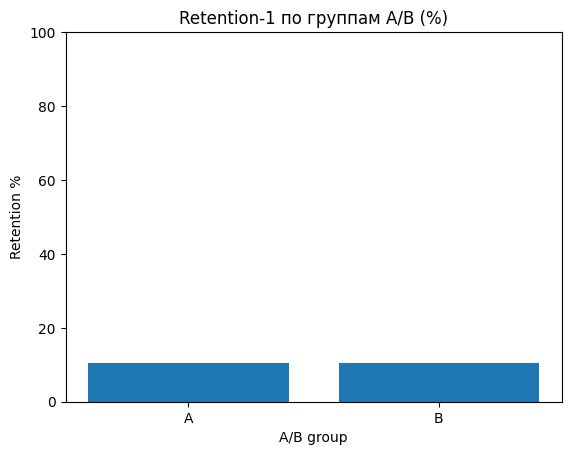

In [16]:
import matplotlib.pyplot as plt

plt.bar(retention_grouped['ab_group'], retention_grouped['retention_rate'] * 100)
plt.title('Retention-1 по группам A/B (%)')
plt.ylabel('Retention %')
plt.xlabel('A/B group')
plt.ylim(0, 100)
plt.show()


## 3. Продуктовая воронка (funnel)


In [17]:
from scipy.stats import ttest_ind, mannwhitneyu

group_A = retention[retention['ab_group'] == 'A']['retention_1']
group_B = retention[retention['ab_group'] == 'B']['retention_1']

# U-тест (безопасный для не-нормальных распределений)
stat, pval = mannwhitneyu(group_A, group_B)
print(f"p-value: {pval:.5f}")


p-value: 0.88717


In [18]:
returned_day_7 = df[df['days_since_first'] == 7][['user_id']].drop_duplicates()
returned_day_7['retention_7'] = 1

# Аналогично соединяю с first_day_users и считаю retention_7 по группам


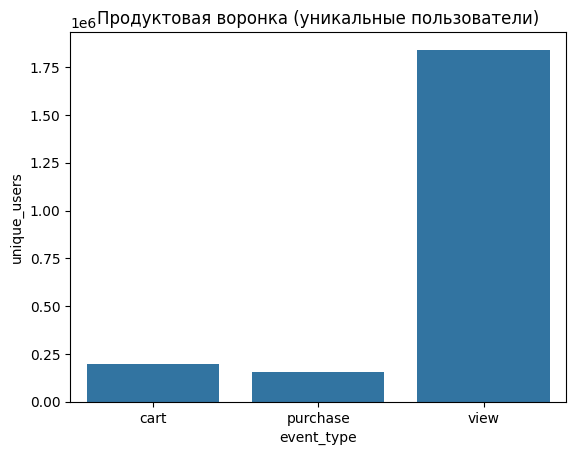

In [19]:
funnel = df.groupby('event_type')['user_id'].nunique().reset_index()
funnel.columns = ['event_type', 'unique_users']

import seaborn as sns
sns.barplot(data=funnel, x='event_type', y='unique_users')
plt.title('Продуктовая воронка (уникальные пользователи)')
plt.show()


In [20]:
funnel_grouped = df.groupby(['ab_group', 'event_type'])['user_id'].nunique().reset_index()
funnel_grouped.columns = ['ab_group', 'event_type', 'unique_users']
funnel_grouped


,ab_group,event_type,unique_users
0,A,cart,98674
1,A,purchase,78080
2,A,view,920248
3,B,cart,98530
4,B,purchase,78269
5,B,view,920953


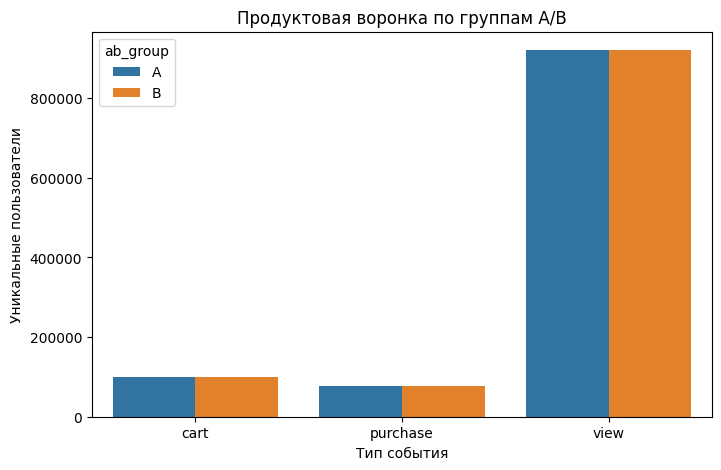

In [21]:
# создаём cohort_date (у тебя это уже есть)
df['cohort_date'] = df['first_event_time'].dt.date

# рисуем график
plt.figure(figsize=(8, 5))
sns.barplot(data=funnel_grouped, x='event_type', y='unique_users', hue='ab_group')
plt.title('Продуктовая воронка по группам A/B')
plt.ylabel('Уникальные пользователи')
plt.xlabel('Тип события')
plt.show()


## 4. Когортный анализ Retention


In [22]:
df['cohort_date'] = df['first_event_time'].dt.date


In [23]:
cohort_pivot = df.groupby(['cohort_date', 'days_since_first'])['user_id'].nunique().reset_index()
cohort_pivot = cohort_pivot.pivot(index='cohort_date', columns='days_since_first', values='user_id')


In [24]:
cohort_size = cohort_pivot[0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)


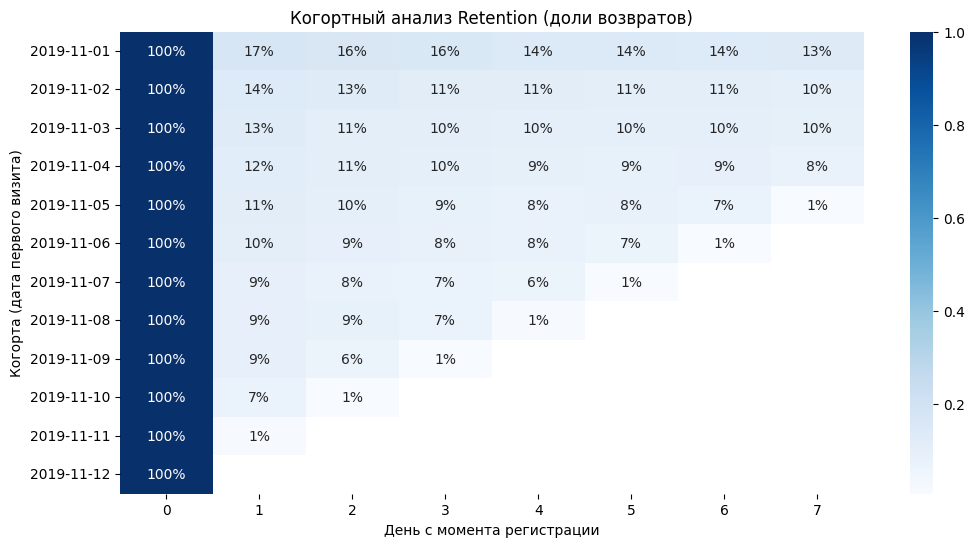

In [25]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(retention_matrix.iloc[:, :8], annot=True, fmt=".0%", cmap="Blues")
plt.title("Когортный анализ Retention (доли возвратов)")
plt.ylabel("Когорта (дата первого визита)")
plt.xlabel("День с момента регистрации")
plt.show()


In [26]:
# Кто вернулся на 7-й день
returned_day_7 = df[df['days_since_first'] == 7][['user_id']].drop_duplicates()
returned_day_7['retention_7'] = 1

# Все, кто появился в 0-й день (первая активность)
target_df = df[df['days_since_first'] == 0][['user_id']].drop_duplicates()
target_df = target_df.merge(returned_day_7, on='user_id', how='left')
target_df['retention_7'] = target_df['retention_7'].fillna(0)


In [27]:
features = df[df['days_since_first'] <= 1].copy()

# Кол-во действий каждого типа
action_counts = features.groupby('user_id')['event_type'].value_counts().unstack().fillna(0)

# Средняя цена
avg_price = features.groupby('user_id')['price'].mean().rename('avg_price')

# Уникальные категории
unique_categories = features.groupby('user_id')['category_code'].nunique().rename('unique_categories')

# Объединяем
X = pd.concat([action_counts, avg_price, unique_categories], axis=1).reset_index()


In [28]:
# Финальная склейка
data = X.merge(target_df, on='user_id')

# Подвыборка
data_sample = data.sample(n=100_000, random_state=42)


## 5. Машинное обучение: прогноз удержания на 7 день


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(
    data_sample.drop(columns=['user_id', 'retention_7']),
    data_sample['retention_7'],
    test_size=0.3,
    random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     28719
         1.0       0.05      0.03      0.04      1281

    accuracy                           0.93     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.92      0.93      0.93     30000

ROC AUC: 0.5856553360907307


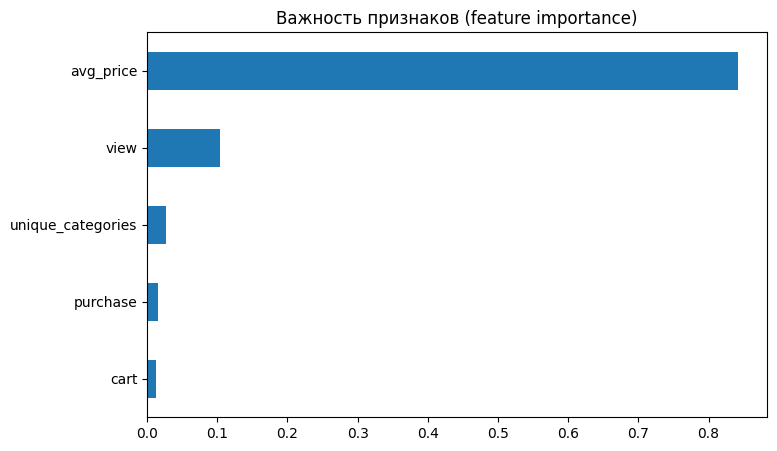

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("Важность признаков (feature importance)")
plt.show()


## 6. Выводы

На основе анализа поведения пользователей интернет-магазина были сделаны следующие выводы:

**Продуктовая воронка** показала стандартное поведение: большинство пользователей только просматривают товары, и лишь небольшая доля добавляет товары в корзину и совершает покупку.

**Retention** (возврат пользователей) на следующий день составляет около **13%**, что является ожидаемым показателем для e-commerce платформы. Retention через 7 дней — заметно ниже.

**A/B тест** показал, что между группами A и B **нет статистически значимой разницы** по Retention (p-value > 0.05). Значит, гипотеза о различии между группами не подтвердилась.

**Когортный анализ** показал ожидаемое снижение возвращаемости пользователей с течением времени. Это нормальное поведение.

**ML-модель (Random Forest)** показала средний результат (ROC AUC ≈ 0.59). Наиболее важным фактором оказался **средний чек пользователя (avg_price)**, что логично: пользователи, покупающие дорогие товары, вероятно, более вовлечены.
